# Imports

In [1]:
import math
import numpy as np
import torch
import torchvision

# Misc
from tqdm import tqdm

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Local imports
import fiberedae.models.fae          as mod
import fiberedae.utils.basic_trainer as vtrain
import fiberedae.utils.persistence   as vpers
import fiberedae.utils.nn            as vnnutils
import fiberedae.utils.plots         as vplots
import fiberedae.utils.fae           as vfae
import fiberedae.utils.datasets      as vdatasets
import fiberedae.utils.useful        as us

json_config = "./geodesics_configurations/olivetti_1d.json"

# Launching geodesics

Loading json...
Loading model ./trained_models/olivetti_4000e.pytorch.mdl...

Manifold plots for source and destination fibers:


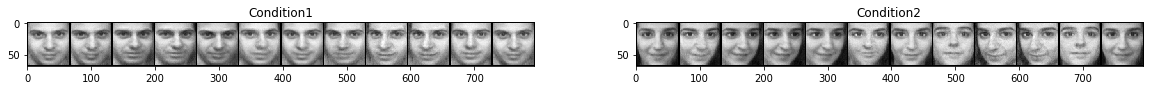

In [2]:
import os
import time
import json
    
print("Loading json...")
config  = json.load(open(json_config))

print("Loading model %s..." % config["model"])
model, optimizer, history, label_encoding = vpers.load_model( config["model"], mod.FiberedAE, map_location="cuda")

label_encoder, label_decoder = label_encoding.transform, label_encoding.inverse_transform
print("")

# Manifold plots: Plots fibers above the two conditions
from launch_geodesics import plot_fiber_manifolds
if config["plot_options"]["latent_grid"]:
    plot = plot_fiber_manifolds( model, 
        condition1 = config["sample_mode"]["src_condition"],
        condition2 = config["sample_mode"]["dst_condition"] )
    print("Manifold plots for source and destination fibers:")
    plot.show()
    plot.close()

In [3]:
# Prepare grid/list of initial points (f,b) depending on the JSON config file
from launch_geodesics import make_fiber_grid
fiber_grid = make_fiber_grid(model, config)

# Pickling job information in output file
import os, pickle
total_count   = len(fiber_grid)
compute_count = np.sum( [ x["src_condition"] != x["dst_condition"] for x in fiber_grid ] )
print( "Pickling job information: %d / %d geodesics to compute..."%(compute_count, total_count) )
if not os.path.exists( config["output"] ):
    os.makedirs( config["output"], exist_ok=True)
try:
    pickle.dump( fiber_grid, open( config["output"] + "fiber_grid_nojob.p", "wb+" ) )
except Exception as error:
    print("Could not pickle:", error)
    
#------------------------------------------
# Initialize module for computing geodesics
from fiberedae.models.geometry import NumericalGeodesics
geodesics_module = NumericalGeodesics( n_max=config["numerics"]["n_max"], step_count=config["numerics"]["step_count"])

# Loop over initial fiber points and compute geodesics
# Note: Multithreaded mode does not work well with jupyter notebooks
#       For that, use launch_geodesics.py in console
geodesics = [None for _ in fiber_grid]
print("Computing geodesics in shooting mode, single-threaded...")
from launch_geodesics import shooting_iteration
for counter in range( len(fiber_grid) ):
    datum     = fiber_grid[counter]
    shooting_iteration( 
        datum["src_fiber"], 
        datum["src_condition"], 
        datum["dst_condition"], 
        counter, 
        geodesics_module=geodesics_module,
        device="cpu",
        epochs=1600, 
        config=config,
        model=model)

# For a fresh start, delete the data saved in "./geodesics_output/*"

Pickling job information: 6 / 6 geodesics to compute...
Computing geodesics in shooting mode, single-threaded...
0. Geodesic already exists!
1. Geodesic already exists!
2. Geodesic already exists!
3. Geodesic already exists!
4. Geodesic already exists!
5. Geodesic already exists!


In [4]:
# Load all geodesics from disc
print("Loading all geodesics from disc and integration into a single data structure...")
for index in range(len(fiber_grid)):
    datum = fiber_grid[index]
    if datum["src_condition"] == datum["dst_condition"]:
        base_point     = model.conditions( torch.tensor( datum["dst_condition"] ) ).detach().cpu().numpy()
        point          = np.concatenate( (datum["src_fiber"], base_point) )
        constant_curve = np.ones( (config["numerics"]["step_count"], 1))*point
        geodesic       = index, constant_curve, constant_curve
    else:
        filename = config["output"] + "geodesic_%05d.p"%index
        stream   = open(filename, "rb")
        geodesic = pickle.load( stream )
        assert(geodesic[0]==index)
        stream.close()
    geodesics[index] = geodesic
# End for
#
print("Cleanup and saving on disk in fiber_grid.p and fiber_grid_endpoints.p ...")
print("")
geodesics_endpoints = []
for (index, naive_curve, geodesic_curve) in geodesics:
    datum     = fiber_grid[index]
    f         = datum["src_fiber"]
    fiber_dim = f.shape[0]
    # Separate geodesic curve into fiber, base, naive and full
    curves = {
        "fiber": geodesic_curve[:, :fiber_dim],
        "base" : geodesic_curve[:, fiber_dim:],
        "full" : geodesic_curve,
        "naive": naive_curve
    }
    datum["curves"]    = curves
    datum["src"]       = curves["full"][ 0,:]
    datum["dst"]       = curves["full"][-1,:]
    datum["src_fiber"] = curves["fiber"][ 0,:]
    datum["dst_fiber"] = curves["fiber"][-1,:]
    datum["src_base" ] = curves["base" ][ 0,:]
    datum["dst_base" ] = curves["base" ][-1,:]
    # Save endpoints separately
    endpoints = {}
    for key in datum:
        if key in ["curves", "neighbors"]:
            continue
        endpoints[key] = datum[key]
    geodesics_endpoints.append( endpoints )
# End for
try:
    pickle.dump( fiber_grid         , open( config["output"] + "fiber_grid.p", "wb+" ) )
    pickle.dump( geodesics_endpoints, open( config["output"] + "fiber_grid_endpoints.p", "wb+" ) )
except Exception as error:
    print("Could not pickle:", error)


Loading all geodesics from disc and integration into a single data structure...
Cleanup and saving on disk in fiber_grid.p and fiber_grid_endpoints.p ...



## Plots

- Plotting 1d projections of geodesics...


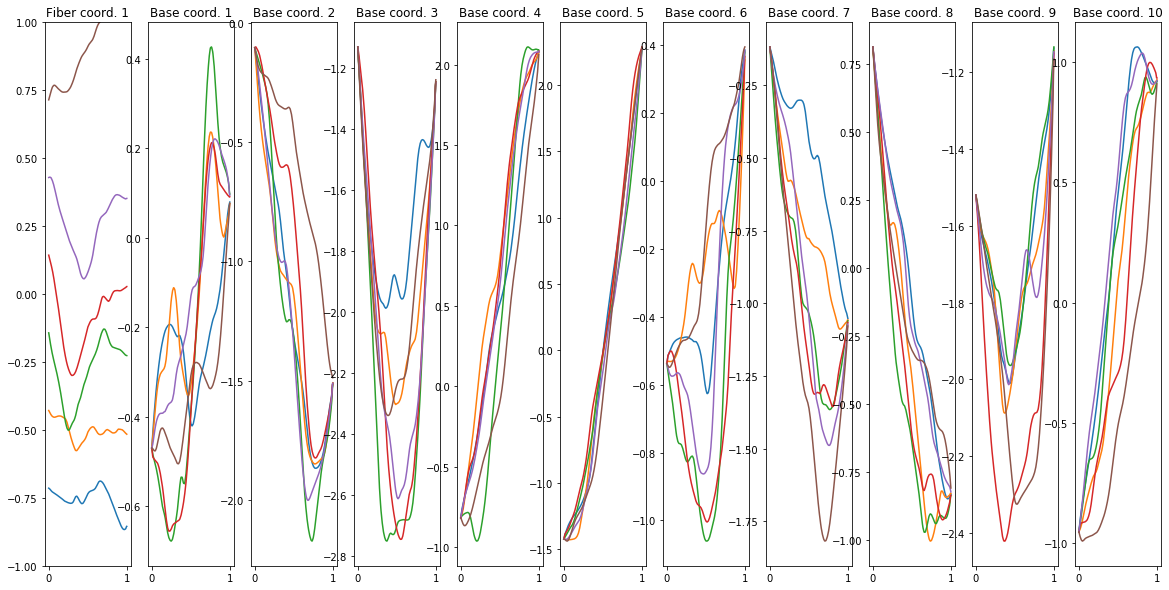

- Plotting naive vs geodesic interpolations...


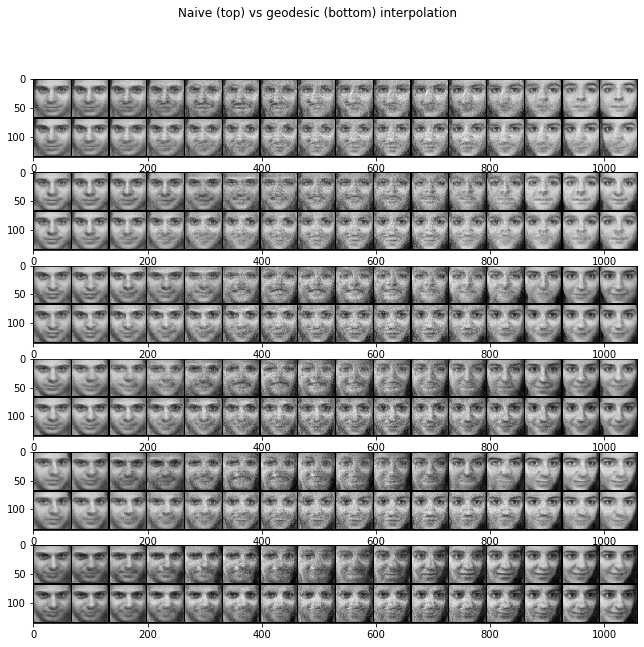

- Plotting energy evolutions...
Blue: Naive curve ; Orange: Geodesic curve


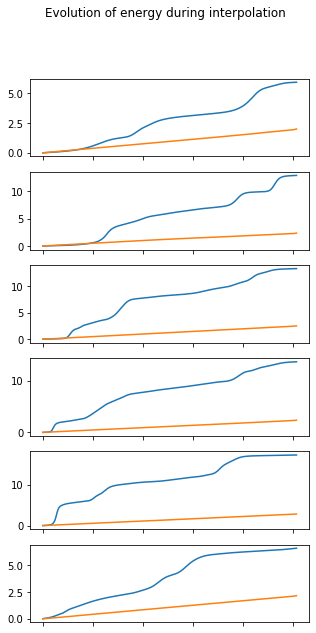

- Plotting correspondence...


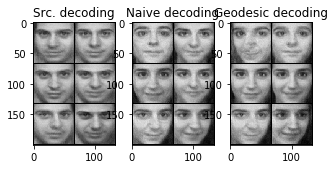

In [6]:
from launch_geodesics import plot_geodesics_1d_projections
from launch_geodesics import plot_diffeomorphism
from launch_geodesics import plot_geodesics_interpolation
from launch_geodesics import plot_energy_evolutions
from launch_geodesics import plot_geodesics_correspondence
from launch_geodesics import plot_geodesics_3d

#Plot 1d projections of geodesics
if config["plot_options"]["geodesics_1d_projections"]:
    print("- Plotting 1d projections of geodesics...")
    time_grid = geodesics_module.time_grid.detach().numpy()
    plot_geodesics_1d_projections( time_grid, fiber_grid )
    plot.show()
    plot.close()

# Grid plot in 2D of diffeomorphism (In geodesic shooting mode only)
if (config["geodesic_mode"]=="shooting") & config["plot_options"]["geodesics_diffeomorphism"]:
    print("- Plotting 2D diffeomorphism...")
    plot = plot_diffeomorphism( fiber_grid )
    plot.show()
    plot.close()

# Interpolation along geodesics the neural network output
if config["plot_options"]["geodesics_interpolation"]:
    print( "- Plotting naive vs geodesic interpolations..." )
    plot = plot_geodesics_interpolation( model, fiber_grid, frames=16)
    plot.show()
    plot.close()

# Energy curves
if config["plot_options"]["geodesics_energy_curves"]:
    print( "- Plotting energy evolutions...")
    print( "Blue: Naive curve ; Orange: Geodesic curve")
    plot = plot_energy_evolutions(model, fiber_grid)
    plot.show()
    plot.close()

# Correspondence for the neural network output
if config["plot_options"]["geodesics_correspondence"]:
    print( "- Plotting correspondence...")
    count     = config["sample_mode"]["geodesics_count"]
    nb_ticks  = math.floor( math.sqrt( count ) )
    plot      = plot_geodesics_correspondence( model, fiber_grid, nb_ticks )
    plot.show()
    plot.close()

# Plot 3D of geodesics
if config["plot_options"]["geodesics_3d"]:
    print( "- Plotting geodesics in 3d...")
    plot = plot_geodesics_3d( time_grid, fiber_grid )
    plot.show()